Nous allons illustrer la méthode de régression logistique pour le problème de classification binaire.
Commençons par importer les modules nécessaires:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Dans cet exemple, nous voulons séparer deux nuages de points `X1` et `X2`, issus de lois gaussiennes:

In [3]:
def points(n): # crée 100 points de classe 0 et 100 points de classe 1
    tX1 = np.random.multivariate_normal([4, 3], 5*np.eye(2), n) # points de classe 0
    tX2 = np.random.multivariate_normal([-2, -1], 5*np.eye(2), n) # points de classe 1
    tX = np.concatenate((tX1, tX2))
    Y = np.array([0]*n + [1]*n) 
    p = np.random.permutation(2*n)
    return tX[p].T, Y[p]

X, Y = points(20) 
print(X.shape, Y.shape)

(2, 40) (40,)


Ainsi, `X[:, i]` est un point (vecteur colonne) dont la classe est `Y[i]`. Le calcul de transposée (`tX[p].T`) sert à rendre les calculs ultérieurs plus simples.
Affichons ces points (rouge: points de classe 0, bleu: points de classe 1):

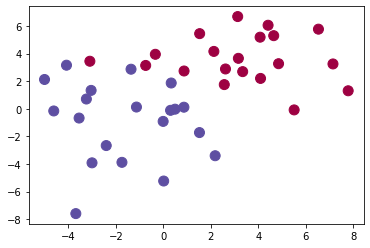

In [4]:
def plot_points(X, Y):
    plt.scatter(X[0], X[1], c = Y, s = 100, cmap = plt.cm.Spectral)
plot_points(X, Y)

La régression logistique permet de séparer linéairement (par un hyperplan, ici une droite) les données. Vu la forme des données, ce modèle semble bien adapté dans notre cas.

Soit $w$ un vecteur colonne de même taille qu'une donnée (ici de taille 2) et $b$ un réel, initialisés arbitrairement. <br>
On définit la **fonction logistique** pour un point x par: $$\sigma(x) = \frac{1}{1+e^{-(w^T x + b)}}$$ <br>
$w^T x$ désigne le produit de deux vecteurs: $w^T$ de taille $(1, 2)$ et $x$ de taille $(2, 1)$, ce qui donne bien un réel. 

On peut de plus remarquer que $\sigma$ est à valeur dans $[0, 1]$. Intuitivement, $\sigma(x)$ va estimer la probabilité que x soit de classe 1: on prédira ainsi que $x$ est dans la classe 0 si $\sigma(x) \leq 0.5$ et que $x$ est dans la classe 1 si $\sigma(x) > 0.5$. <br>
Il n'y a évidemment aucune raison pour que $\sigma$ soit un bon prédicteur initialement, mais nous allons modifier itérativement $w$ et $b$ en espérant améliorer la qualité de prédiction. 

In [5]:
def init(n):
    X, Y = points(n)
    w = np.array([[0],[1]]) # initialisation arbitraire de w et b
    b = 0
    return w, b, X, Y
    
def sigmoid(w, b, x):
    return 1/(1 + np.exp(-(np.dot(w.T, x) + b)))

def predict(w, b, x):
    return np.round(sigmoid(w, b, x)) # renvoie la prédiction de classe pour x

def precision(w, b, x, Y):
    P = predict(w, b, X)
    return float(np.sum(P == Y, axis = 1)/len(Y)) # renvoie le pourcentage de prédictions correctes

Grâce aux propriétés des tableaux numpy, $\sigma$(`X`) est bien défini et applique $\sigma$ à chaque colonne de `X`. C'est donc un vecteur $\hat{Y}$ tel que $\hat{Y}[i]$ soit la probabilité estimée que `X[i]` soit de classe 1.

Pour quantifier notre qualité de prédiction, on utilise une **fonction de coût** (ou **loss function**), qui mesure une distance de $\hat Y$ à $Y$. Plusieurs choix sont possibles mais la plus fréquente est la suivante, où $m$ est le nombre de données (nombre de points): 

$$\mathcal{L}(\hat{Y}, Y) = \frac{-1}{m} \sum_{i = 0}^{m-1} Y[i] \log(\hat{Y}[i]) + (1 - Y[i]) \log(1 - \hat{Y}[i])$$

Remarquons que si $Y[i] = 1$, $Y[i] \log(\hat{Y}[i]) + (1 - Y[i]) \log(1 - \hat{Y}[i] = \log(\hat{Y}[i])$ augmente la valeur de $\mathcal{L}(\hat{Y}, Y)$ d'autant plus que $\hat{Y}[i]$ est proche de 0 (c'est à dire que la prévision est mauvaise), et de même si $Y[i] = 0$. <br>
$\mathcal{L}(\hat{Y}, Y)$ mesure donc bien à quel point $\hat{Y}$ et $Y$ sont proches. <br>
De plus, comme $\hat{Y}$ ne dépend que de $w$ et $b$ et que $Y$ va rester fixé, lors de notre algorithme, on peut aussi voir $\mathcal{L}$ comme une fonction de $w$ et $b$. 

Ce choix particulier de fonction de coût pour la regression logistique est motivé par le fait qu'on obtient une fonction **convexe** et donc qu'un minimum local est aussi un minimum global, c'est à dire un choix de $w$ et $b$ le plus proche possible de $Y$. L'utilisation d'une erreur quadratique moyenne, par exemple, ne donnerait pas de telles propriétés pour la régression logistique.

Afin de minimiser $\mathcal{L}(\hat{Y}, Y)$, nous allons utiliser l'**algorithme du gradient**. Intuitivement, le gradient indiquant dans quelle direction une fonction augmente, il faut se déplacer dans le sens inverse pour diminuer la fonction, coefficienté par un réel $a$. <br>
Autrement dit, la méthode consiste à répéter un certain nombre de fois:
- $w \longleftarrow w - a \frac{\partial \mathcal{L}}{\partial w}$
- $b \longleftarrow b - a \frac{\partial \mathcal{L}}{\partial b}$

Le lecteur pourra vérifier que l'on trouve les égalités suivantes:

- $\frac{\partial \mathcal{L}}{\partial w} = \frac{1}{m} X (\hat Y - Y)^T$
- $\frac{\partial \mathcal{L}}{\partial b} = \frac{1}{m} \sum \hat Y[i] - Y[i]$

Ce qui conduit à l'implémentation suivante, où on a aussi affiché la précision en fonction de l'itération en cours:

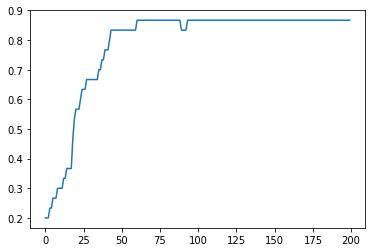

In [6]:
def gradient_desc(w, b, X, Y, a, n):
    m = X.shape[1] # nombre de points
    P = []
    for i in range(n): # répéter n fois
        P.append(precision(w, b, X, Y))
        Yhat = sigmoid(w, b, X)
        dw = np.dot(X, (Yhat - Y).T)/m
        db = np.sum(Yhat - Y)/m
        w = w - a*dw
        b = b - a*db
    plt.plot([i for i in range(n)], P)
    return w, b 

w, b, X, Y = init(15)
w, b = gradient_desc(w, b, X, Y, 0.01, 200)

Le lecteur pourra s'amuser à changer les valeurs des paramètres (a, n, nombre de points)... <br>
Affichons maintenant graphiquement les prédictions réalisées, en utilisant la fonction plot_decision_boundary ci-dessous, honteusement trouvée sur Internet:

In [7]:
def plot_decision_boundary(pred_func, X, Y):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c = Y, s = 100, cmap=plt.cm.Spectral)

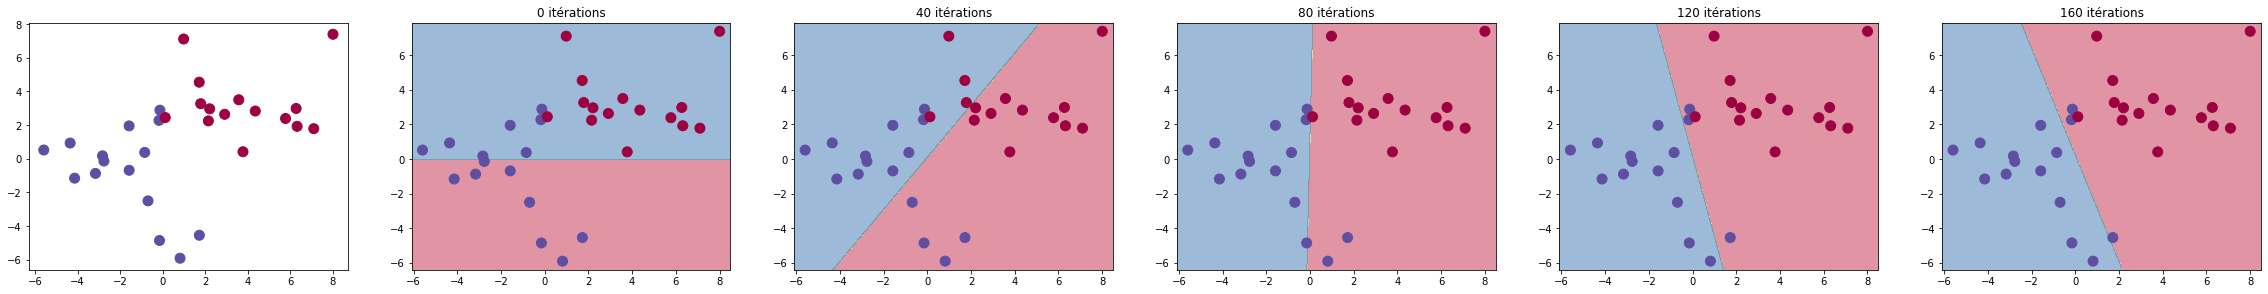

In [26]:
def gradient_desc(w, b, X, Y, a, n):
    m = X.shape[1] # nombre de points
    nb_fig = n//40 + 1 # nombre de figures
    plt.rcParams['figure.figsize'] = (40.0, 10.0)
    plt.subplot(2,nb_fig, 1)
    plot_points(X, Y)
    i_fig = 1 # figure en cours de dessin
    for i in range(n): # répéter n fois
        if i % 40 == 0:
            i_fig += 1
            plt.subplot(2, n//40+1, i_fig)
            plt.title(str(i) + " itérations")
            plot_decision_boundary(lambda x: predict(w, b, x.T), X.T, Y)
        Yhat = sigmoid(w, b, X)
        dw = np.dot(X, (Yhat - Y).T)/m
        db = np.sum(Yhat - Y)/m
        w = w - a*dw
        b = b - a*db
    return w, b 

w, b, X, Y = init(15)
w, b = gradient_desc(w, b, X, Y, 0.01, 200)

Remarquons que ce modèle est bien linéaire: en effet $\sigma(x) = 0.5 \Longleftrightarrow w^T x + b = 0$ est l'équation d'une droite, comme on peut le voir sur les images ci-dessus. <br>
Dans le cas où les données ne sont pas linéairement séparables, d'autres méthodes existent comme les réseaux de neurones ou les arbres de décision.